In [146]:
import logging

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
import os
import scipy
import seaborn as sns

# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None

import azureml.core
from azureml.core import Experiment, Workspace, Dataset
from azureml.train.automl import AutoMLConfig
from datetime import datetime

In [3]:
target_column_name = 'demand'
time_column_name = 'timeStamp'

In [4]:
# Not sure but Tabular dataset are good with timeseries?
dataset = Dataset.Tabular.from_delimited_files(path = "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/nyc_energy.csv").with_timestamp_columns(fine_grain_timestamp=time_column_name) 

In [6]:
# FIX NULL VALUES HERE LATER!!!

data2014 = dataset.time_between(datetime(2014, 1, 1,0), datetime(2014, 12, 12,23))
data2014 = data2014.drop_columns('precip') #just for this dataset
data2014 = data2014.to_pandas_dataframe().reset_index(drop=True).sort_values(time_column_name)
y2014 = data2014['demand']
x2014 = data2014['timeStamp']

data2013 = dataset.time_between(datetime(2013, 1, 1,0), datetime(2013, 12, 12,23))
data2013 = data2013.drop_columns('precip') #just for this dataset
data2013 = data2013.to_pandas_dataframe().reset_index(drop=True).sort_values(time_column_name)
y2013 = data2013['demand']
x2013 = data2013['timeStamp']

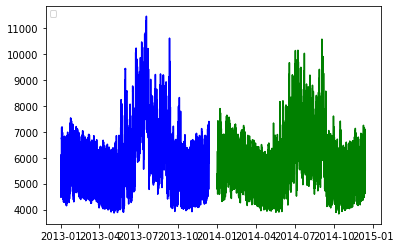

In [14]:
%matplotlib inline
res1 = plt.plot(x2013,y2013)
res2 = plt.plot(x2014,y2014)
plt.legend((res1,res2),('2013','2014'), loc='upper left', fontsize=8)
plt.show()

In [140]:
# Function that takes a sorted list of load demand 
# values and produces a plot of the load duration curve.

def plot_load_duration_curve(sorted_demand_list):
    list_len = len(sorted_demand_list) #Number of datapoints
    x = np.linspace(1,list_len,list_len).tolist() #List of hours
    
    plt.plot(x,sorted_demand_list)
    plt.title('Load Duration curve')
    plt.xlabel('Hours')
    plt.ylabel('Consumption [kWh]') #Review if kwh or not later on
    

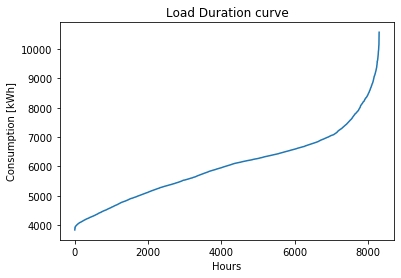

In [24]:
# just testing the plot_load_duration_curve-function

x13 = data2013['demand'].dropna().sort_values().tolist()
plot_load_duration_curve(x14)


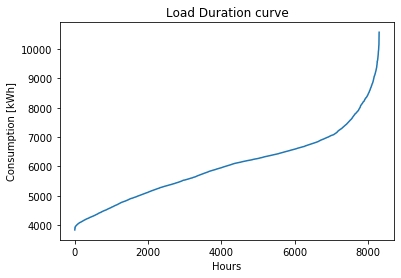

In [25]:
# just testing the plot_load_duration_curve-function
x14 = data2014['demand'].dropna().sort_values().tolist()
plot_load_duration_curve(x14)

In [32]:
mu13, std13 = scipy.stats.norm.fit(x13)
mu14, std14 = scipy.stats.norm.fit(x14)
print('2013 mean consumption: '+ str(mu13) + ' (-/+ '+ str(std13) + ')')
print('2014 mean comsumption: '+ str(mu14) + ' (-/+ '+ str(std14) + ')')

2013 mean consumption: 6104.211718655907 (-/+ 1320.7101708205694)
2014 mean comsumption: 6019.08949777189 (-/+ 1168.4773284994344)


# Working with Time Series

In [37]:
#parse timestamp col as dates
nyc_daily = pd.read_csv('nyc_energy.csv', index_col=0, parse_dates=True)

In [59]:
nyc_daily.index.names = ['Date']
nyc_daily.head()

,demand,precip,temp,Year,Month,Weekday Name
Date,,,,,,
2012-01-01 00:00:00,4937.50,0.00,46.13,2012,1,Sunday
2012-01-01 01:00:00,4752.10,0.00,45.89,2012,1,Sunday
2012-01-01 02:00:00,4542.60,0.00,45.04,2012,1,Sunday
2012-01-01 03:00:00,4357.70,0.00,45.03,2012,1,Sunday
2012-01-01 04:00:00,4275.50,0.00,42.61,2012,1,Sunday


In [57]:
# Add columns with year, month, and weekday name
nyc_daily['Year'] = nyc_daily.index.year
nyc_daily['Month'] = nyc_daily.index.month
nyc_daily['Weekday Name'] = nyc_daily.index.weekday_name
# Display a random sampling of 5 rows
nyc_daily.sample(5, random_state=0)

,demand,precip,temp,Year,Month,Weekday Name
timeStamp,,,,,,
2014-04-15 10:00:00,6294.70,0.09,58.77,2014,4,Tuesday
2016-05-05 20:00:00,5811.84,0.00,53.55,2016,5,Thursday
2013-11-16 08:00:00,4970.20,0.01,47.09,2013,11,Saturday
2012-02-14 18:00:00,6694.60,0.00,43.26,2012,2,Tuesday
2012-09-10 16:00:00,7437.90,0.00,68.46,2012,9,Monday


In [41]:
subset_nyc_daily = nyc_daily.loc['2014-01-20':'2014-01-22']

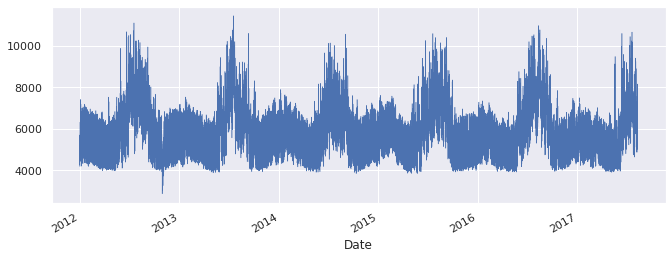

In [60]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})
nyc_daily['demand'].plot(linewidth=0.5);

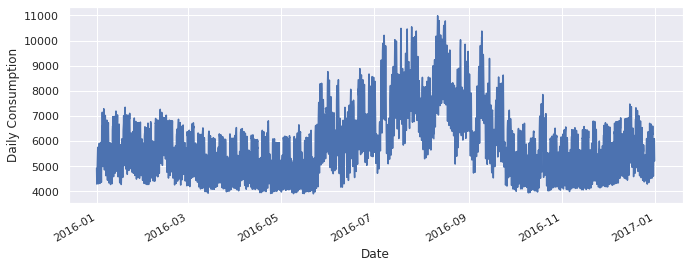

In [64]:
ax = nyc_daily.loc['2016', 'demand'].plot()
ax.set_ylabel('Daily Consumption');

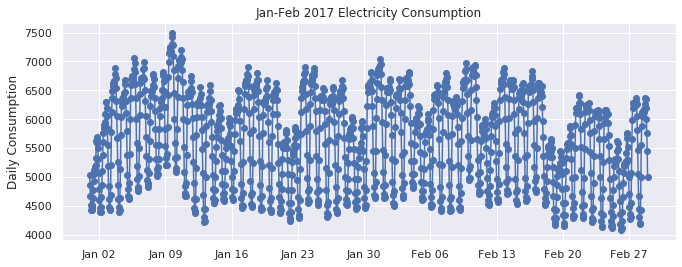

In [66]:
import matplotlib.dates as mdates
# This doesn't seem to be working. Depricated?

fig, ax = plt.subplots()
ax.plot(nyc_daily.loc['2017-01':'2017-02', 'demand'], marker='o', linestyle='-')
ax.set_ylabel('Daily Consumption')
ax.set_title('Jan-Feb 2017 Electricity Consumption')
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

Text(0.5, 1, 'demand')

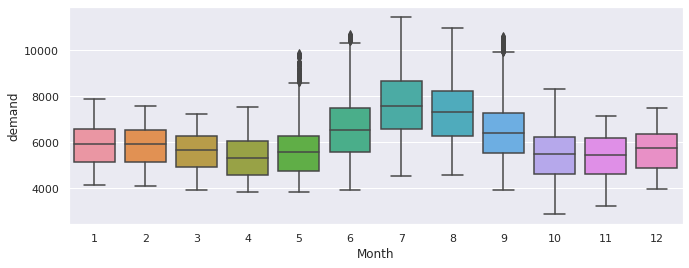

In [72]:
sns.boxplot(data=nyc_daily, x='Month', y='demand')
ax.set_ylabel('GWh')
ax.set_title('demand')

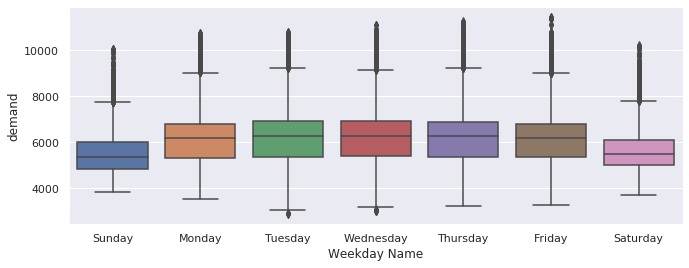

In [73]:
sns.boxplot(data=nyc_daily, x='Weekday Name', y='demand');

In [77]:
data_columns = ['temp', 'demand']
nyc_weekly_mean = nyc_daily[data_columns].resample('W').mean()
nyc_daily_mean = nyc_daily[data_columns].resample('D').mean()

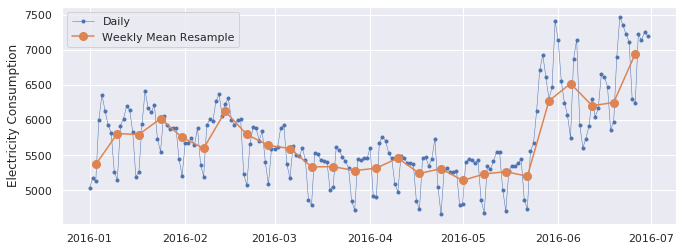

In [83]:
# Start and end of the date range to extract
start, end = '2016-01', '2016-06'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots()
ax.plot(nyc_daily_mean.loc[start:end, 'demand'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(nyc_weekly_mean.loc[start:end, 'demand'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.set_ylabel('Electricity Consumption')
ax.legend();

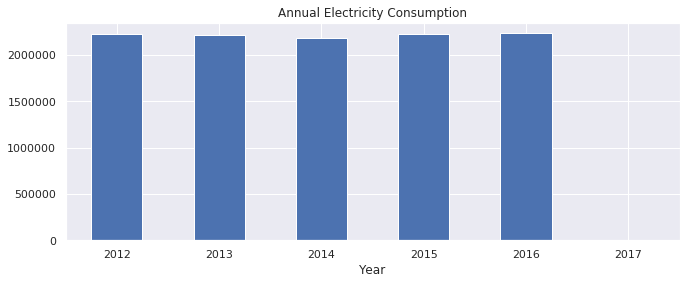

In [89]:
# Compute the annual sums, setting the value to NaN for any year which has
# fewer than 360 days of data
nyc_annual = nyc_daily_mean[data_columns].resample('A').sum(min_count=360)
# The default index of the resampled DataFrame is the last day of each year,
# ('2006-12-31', '2007-12-31', etc.) so to make life easier, set the index
# to the year component
nyc_annual = nyc_annual.set_index(nyc_annual.index.year)
nyc_annual.index.name = 'Year'
nyc_annual.tail(3)

# Plot from 2012 onwards
ax = nyc_annual.loc[2012:, 'demand'].plot.bar(color='C0')
ax.set_title('Annual Electricity Consumption')
plt.xticks(rotation=0);

# Claes test data

In [135]:
claes_data = pd.read_csv('claes_test.csv', index_col=0, parse_dates=True)

In [136]:
# drop everthing but the load columns
claes_data.drop(columns=['Temperature','aggLoad'], inplace=True)
claes_data.head()

,V2,V3,V4,V5,V6,V7,V8,V9,V10
TimeDate,,,,,,,,,
2018-04-24 00:00:00,2.70,0.00,2.72,2.60,1.40,1.20,1.10,1.30,1.60
2018-04-24 01:00:00,2.60,0.00,2.39,3.20,1.00,1.20,1.10,1.20,1.40
2018-04-24 02:00:00,2.80,0.00,1.79,3.00,1.30,1.10,1.10,1.40,1.30
2018-04-24 03:00:00,2.60,0.00,1.78,3.00,1.30,1.20,1.10,1.90,1.10
2018-04-24 04:00:00,2.60,0.00,2.07,3.30,0.80,1.20,1.10,1.20,1.10


In [137]:
# Function which takes a dataframe where
# each column represents a load and rows = date/time
# returns same dataframe but with a aggregated column.

def add_aggregated_col(dataframe):
    dataframe.sort_index(inplace=True) # making sure df is sorted
    dataframe['AggregatedLoad'] = dataframe.sum(numeric_only=True, axis=1) # add new sum col
    return dataframe

In [139]:
def from_df_to_sorted_lst(dataframe):
    sorted_load_list = dataframe['AggregatedLoad'].sort_values().tolist()
    return sorted_load_list

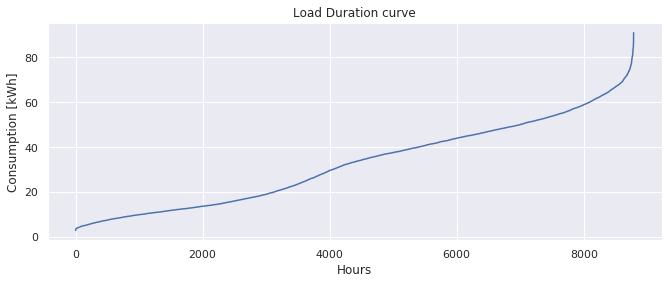

In [141]:
# testing the functions with Claes test data

df = add_aggregated_col(claes_data)
lst = from_df_to_sorted_lst(df)

plot_load_duration_curve(lst)

# Input Skeleton

In [ ]:
#kanske ha regioner + urban/rual?
#kanske ha alla inputparametrar som en dictionary?

houses = 5
houses_DH = 5 #fjärrvärme
prob_PV = 0.3 #påverka hus bara just nu
prob_EV = 0.5 #påverka hus bara just nu

appartments = 10
appartments_DH = 10

flexibility_impact = 0.1 #säkna toppar med 10%
efficiency_impact = 0.1 #sänka allt med 10%